In [21]:
import os
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import LinearLR
import torchvision.transforms.functional as TF
from torch.nn import functional as F
from math import exp

# The hdf5 X_jets dataset was converted to a zip and used as a private dataset on kaggle 
class DeepFalconData(Dataset):
    def __init__(self, data_dir, transform=None, target_size=(128, 128)):
        self.data_dir = data_dir
        self.transform = transform
        self.target_size = target_size
        
    def __len__(self):
        return 10000 #len(os.listdir(self.data_dir))

    def __getitem__(self, idx):
        # resize and normalize each datapoint
        image = np.load(os.path.join(self.data_dir, f"{idx}.npy"))  # (H, W, C)
        image = (image - image.min()) / (image.max() - image.min() + 1e-6)
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) 
        image = TF.resize(image, self.target_size, antialias=True)

        return image


In [22]:
batch_size = 128

dataset = DeepFalconData(data_dir='/kaggle/input/task-1/content/sample_data/deepfalcon_1/train_jets', transform=ToTensor())
train_len = int(len(dataset)*0.95)
train_set, test_set = random_split(dataset, [train_len, len(dataset)-train_len])
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size,shuffle=True)

In [23]:
# Save directly to Kaggle's output folder
CHECKPOINT_DIR = "/kaggle/working"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def save_checkpoint(model, optimizer, epoch, filename="vae_checkpoint.pth"):
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }
    filepath = os.path.join(CHECKPOINT_DIR, filename)
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at {filepath}")


In [24]:
# Adapted from the AntixK/PyTorch-VAE project on github 

class VAE(nn.Module):

  def __init__(self, input_channels : int, latent_dim : int, hidden_dims = [32, 64, 128, 256]):
    super(VAE, self).__init__()
    self.input_channels = input_channels
    self.latent_dim = latent_dim
    self.hidden_dims = hidden_dims
    modules = []
    for h_dim in self.hidden_dims:
      modules.append(
                nn.Sequential(
                    nn.Conv2d(input_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
      input_channels = h_dim
    self.encoder = nn.Sequential(*modules)
    self.mean = nn.Linear(hidden_dims[-1]*64, latent_dim)
    self.log_var = nn.Linear(hidden_dims[-1]*64, latent_dim)

    modules = []

    self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1]*64)
    hidden_dims.reverse()

    for i in range(len(hidden_dims) - 1):
      modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )
    self.decoder = nn.Sequential(*modules)

    self.final_layer = nn.Sequential(
                        nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                        nn.BatchNorm2d(hidden_dims[-1]),
                        nn.LeakyReLU(),
                        nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1)
                        )

  def encode(self, x):

    x = self.encoder(x)
    x = torch.flatten(x, start_dim=1)
    mean = self.mean(x)
    log_var = self.log_var(x)

    return mean, log_var

  def decode(self, x):

    x = self.decoder_input(x)
    x = x.view(-1, self.hidden_dims[0], 8, 8)
    x = self.decoder(x)
    x = self.final_layer(x)

    return x

  def reparameterize(self, mean, log_var):

    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return eps * std + mean

  def forward(self, x):

    mean, log_var = self.encode(x)
    z = self.reparameterize(mean, log_var)
    x_reconst = self.decode(z)

    return x_reconst, mean, log_var


In [25]:
# The MSSIM loss can be used as component of the reconstruction loss
class MSSIM(nn.Module):

    def __init__(self,
                 in_channels: int = 3,
                 window_size: int=11,
                 size_average:bool = True) -> None:
        """
        Computes the differentiable MS-SSIM loss
        Reference:
        [1] https://github.com/jorge-pessoa/pytorch-msssim/blob/dev/pytorch_msssim/__init__.py
            (MIT License)

        :param in_channels: (Int)
        :param window_size: (Int)
        :param size_average: (Bool)
        """
        super(MSSIM, self).__init__()
        self.in_channels = in_channels
        self.window_size = window_size
        self.size_average = size_average

    def gaussian_window(self, window_size:int, sigma: float) -> torch.Tensor:
        kernel = torch.tensor([exp((x - window_size // 2)**2/(2 * sigma ** 2))
                               for x in range(window_size)])
        return kernel/kernel.sum()

    def create_window(self, window_size, in_channels):
        _1D_window = self.gaussian_window(window_size, 1.5).unsqueeze(1)
        _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
        window = _2D_window.expand(in_channels, 1, window_size, window_size).contiguous()
        return window

    def ssim(self,
             img1: torch.Tensor,
             img2: torch.Tensor,
             window_size: int,
             in_channel: int,
             size_average: bool) -> torch.Tensor:

        device = img1.device
        window = self.create_window(window_size, in_channel).to(device)
        mu1 = F.conv2d(img1, window, padding= window_size//2, groups=in_channel)
        mu2 = F.conv2d(img2, window, padding= window_size//2, groups=in_channel)

        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2

        sigma1_sq = F.conv2d(img1 * img1, window, padding = window_size//2, groups=in_channel) - mu1_sq
        sigma2_sq = F.conv2d(img2 * img2, window, padding = window_size//2, groups=in_channel) - mu2_sq
        sigma12   = F.conv2d(img1 * img2, window, padding = window_size//2, groups=in_channel) - mu1_mu2

        img_range = 1.0 #img1.max() - img1.min() # Dynamic range
        C1 = (0.01 * img_range) ** 2
        C2 = (0.03 * img_range) ** 2

        v1 = 2.0 * sigma12 + C2
        v2 = sigma1_sq + sigma2_sq + C2
        cs = torch.mean(v1 / v2)  # contrast sensitivity

        ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

        if size_average:
            ret = ssim_map.mean()
        else:
            ret = ssim_map.mean(1).mean(1).mean(1)
        return ret, cs

    def forward(self, img1: torch.Tensor, img2: torch.Tensor) -> torch.Tensor:
        device = img1.device
        weights = torch.FloatTensor([0.0448, 0.2856, 0.3001, 0.2363, 0.1333]).to(device)
        levels = weights.size()[0]
        mssim = []
        mcs = []

        for _ in range(levels):
            sim, cs = self.ssim(img1, img2,
                                self.window_size,
                                self.in_channels,
                                self.size_average)
            mssim.append(sim)
            mcs.append(cs)

            img1 = F.avg_pool2d(img1, (2, 2))
            img2 = F.avg_pool2d(img2, (2, 2))

        mssim = torch.stack(mssim)
        mcs = torch.stack(mcs)

        # # Normalize (to avoid NaNs during training unstable models, not compliant with original definition)
        # if normalize:
        #     mssim = (mssim + 1) / 2
        #     mcs = (mcs + 1) / 2

        pow1 = mcs ** weights
        pow2 = mssim ** weights

        output = torch.prod(pow1[:-1] * pow2[-1])
        return 1 - output

In [49]:
# Since each datapoint has more zeros than non-zero values a weighetd mse is taken applying higher weigtages to non-zero values

def weighted_mse(x_recon, x_true):

    mask_1 = (x_true > 0) * 1.
    mask_2 = (x_true == 0) * 1.
    #num of 1's
    num_pos = mask_1.sum(dim=(-1, -2, -3))
    #num of 0's
    num_neg = mask_2.sum(dim=(-1, -2, -3))
    weight_1 = num_neg / (num_pos + 1e-6)
    #weight_2 = num_pos / (num_neg + 1e-6)
    mask_1 *= weight_1[:,None,None,None]
    #mask_2 *= weight_2[:,None,None,None]
    weights = mask_2 * 6 + mask_1
    weights = weights.to(x_recon.device)
    mse = nn.MSELoss(reduction='none')(x_recon, x_true)
    weighted_mse = torch.sum((weights * mse))
    return weighted_mse

In [50]:
# The final beta loss of the VAE
def beta_loss(x_recon, x_true, log_var, mean, beta, epoch):

  recon_loss = weighted_mse(x_recon, x_true)
  kld = torch.mean(-0.5 * torch.sum(1 + log_var - mean ** 2 - log_var.exp(), dim = 1), dim = 0)
  return beta * kld  + recon_loss , recon_loss, kld

In [51]:
# A scheduler for the beta value in beta loss function(importance of KL Divergence term).
def kl_linear_anneal(step, total_steps):
    return min(1.0, step * 2 / (total_steps))

In [52]:
import torch
from torch.nn.parallel import DataParallel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model = VAE(3, 128).to(device)
VAE_model = DataParallel(VAE_model)
optimizer = torch.optim.Adam(VAE_model.parameters(), lr=1e-4)

In [53]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

def train_vae(VAE_model, train_dataloader, test_dataloader, optimizer, device, epochs=20):
    beta = 0
    for epoch in range(epochs):
        epoch_loss, epoch_recon_loss, epoch_kld = 0, 0, 0
        
        beta = 1
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        
        for batch_idx, batch in enumerate(progress_bar):
            batch = batch.to(device)
            optimizer.zero_grad()

            # Forward pass
            x_recon, mean, log_var = VAE_model(batch)
            loss, recon_loss, kld= beta_loss(x_recon, batch, log_var, mean, beta, epoch)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kld += kld.item()
            
            # Update progress bar
            progress_bar.set_postfix(loss=f"{loss.item():.4f}", recon=f"{recon_loss.item():.4f}", kld=f"{kld.item():.4f}")
            #if batch_idx % 1000 == 0:
            #   validate_vae(VAE_model, test_dataloader, beta_loss, device, epoch+1)

        # Print final epoch loss

        print(f"Epoch {epoch+1} | Loss: {epoch_loss/len(train_dataloader):.6f} | "
              f"Recon Loss: {epoch_recon_loss/len(train_dataloader):.6f} | "
              f"KLD: {epoch_kld/len(train_dataloader):.6f}")

        # Validation & Visualization
        if (epoch + 1) % 20 == 0:  # Run validation every 20 epochs
            validate_vae(VAE_model, test_dataloader, beta_loss, device, epoch+1)
            save_checkpoint(VAE_model, optimizer, epoch, filename="vae_checkpoint_" + str(epoch) + ".pth")

def validate_vae(VAE_model, test_dataloader, beta_loss, device, epoch):

    VAE_model.eval()
    with torch.no_grad():
        for batch_idx, test_batch in enumerate(test_dataloader):
            test_batch = test_batch.to(device)
            x_recon, mean, log_var = VAE_model(test_batch)
            loss, recon_loss, kld = beta_loss(x_recon, test_batch, log_var, mean, 1, epoch - 1)  # Use beta=1 for test

            print(f"Test Epoch {epoch} | Loss: {loss:.6f} | Recon Loss: {recon_loss:.6f} | KLD: {kld:.6f}")

            visualize_reconstructions(test_batch, x_recon, num_samples=2)
            if batch_idx % 5:
                break  # Only visualize once per epoch

def visualize_reconstructions(originals, reconstructions, num_samples=4):

    num_samples = min(num_samples, originals.shape[0])
    fig, axes = plt.subplots(num_samples, 6, figsize=(15, 3 * num_samples))

    for idx in range(num_samples):
        original = originals[idx].cpu().numpy()
        reconstructed = reconstructions[idx].cpu().numpy()

        for c in range(3):  # Loop over 3 channels
            axes[idx, c].imshow(original[c, :, :])
            axes[idx, c].set_title(f"Original - Channel {c+1}")

            axes[idx, c + 3].imshow(reconstructed[c, :, :])
            axes[idx, c + 3].set_title(f"Reconstructed - Channel {c+1}")

    plt.show()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))
    for idx in range(num_samples):
        recon_mask = (reconstructed[idx] >= 0)
        reconstructed = (reconstructions[idx].cpu().numpy() * recon_mask)

        for c in range(3):
            axes[idx, c].imshow(reconstructed[c, :, :])
            axes[idx, c].set_title(f"Reconstructed - Channel {c+1}")
    plt.show()

Epoch 1/30: 100%|██████████| 75/75 [01:03<00:00,  1.19it/s, kld=86.8830, loss=13084.6250, recon=12997.7422]    


Epoch 1 | Loss: 677972.511458 | Recon Loss: 677921.643177 | KLD: 50.864881


Epoch 2/30: 100%|██████████| 75/75 [01:03<00:00,  1.17it/s, kld=220.0556, loss=4851.8154, recon=4631.7598]  


Epoch 2 | Loss: 34545.548242 | Recon Loss: 34388.336458 | KLD: 157.211751


Epoch 3/30: 100%|██████████| 75/75 [01:03<00:00,  1.17it/s, kld=330.8916, loss=3385.2737, recon=3054.3821]  


Epoch 3 | Loss: 16854.314443 | Recon Loss: 16584.847217 | KLD: 269.467170


Epoch 4/30: 100%|██████████| 75/75 [01:06<00:00,  1.12it/s, kld=372.3990, loss=2851.5056, recon=2479.1067]  


Epoch 4 | Loss: 11893.713786 | Recon Loss: 11554.699730 | KLD: 339.014016


Epoch 5/30: 100%|██████████| 75/75 [01:06<00:00,  1.13it/s, kld=401.5809, loss=2371.6497, recon=1970.0687]  


Epoch 5 | Loss: 9730.882673 | Recon Loss: 9352.590396 | KLD: 378.292318


Epoch 6/30: 100%|██████████| 75/75 [01:04<00:00,  1.17it/s, kld=415.3592, loss=2062.1216, recon=1646.7625]


Epoch 6 | Loss: 8529.925273 | Recon Loss: 8131.606097 | KLD: 398.319201


Epoch 7/30: 100%|██████████| 75/75 [01:06<00:00,  1.12it/s, kld=429.5005, loss=1921.1718, recon=1491.6713]


Epoch 7 | Loss: 7776.002889 | Recon Loss: 7370.327205 | KLD: 405.675678


Epoch 8/30: 100%|██████████| 75/75 [01:07<00:00,  1.12it/s, kld=376.3639, loss=1874.4401, recon=1498.0762]


Epoch 8 | Loss: 7253.849657 | Recon Loss: 6850.335775 | KLD: 403.513835


Epoch 9/30: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s, kld=366.5142, loss=1648.3535, recon=1281.8394]


Epoch 9 | Loss: 6875.050605 | Recon Loss: 6480.692585 | KLD: 394.358018


Epoch 10/30: 100%|██████████| 75/75 [01:06<00:00,  1.12it/s, kld=387.0118, loss=1610.7422, recon=1223.7303]


Epoch 10 | Loss: 6581.122318 | Recon Loss: 6198.496170 | KLD: 382.626160


Epoch 11/30: 100%|██████████| 75/75 [01:06<00:00,  1.12it/s, kld=378.9091, loss=1604.4540, recon=1225.5449]


Epoch 11 | Loss: 6350.015773 | Recon Loss: 5980.538698 | KLD: 369.477074


Epoch 12/30: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s, kld=340.2052, loss=1562.5232, recon=1222.3180]


Epoch 12 | Loss: 6163.259919 | Recon Loss: 5807.463953 | KLD: 355.795979


Epoch 13/30: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s, kld=333.7917, loss=1703.4690, recon=1369.6772]


Epoch 13 | Loss: 6024.088857 | Recon Loss: 5681.100417 | KLD: 342.988438


Epoch 14/30: 100%|██████████| 75/75 [01:06<00:00,  1.12it/s, kld=332.6232, loss=1360.7893, recon=1028.1660]


Epoch 14 | Loss: 5893.695264 | Recon Loss: 5563.078841 | KLD: 330.616444


Epoch 15/30: 100%|██████████| 75/75 [01:06<00:00,  1.12it/s, kld=321.5007, loss=1356.3264, recon=1034.8257]


Epoch 15 | Loss: 5770.854867 | Recon Loss: 5450.903542 | KLD: 319.951326


Epoch 16/30: 100%|██████████| 75/75 [01:06<00:00,  1.12it/s, kld=301.6525, loss=1585.0811, recon=1283.4286]


Epoch 16 | Loss: 5808.187272 | Recon Loss: 5499.451216 | KLD: 308.736051


Epoch 17/30: 100%|██████████| 75/75 [01:07<00:00,  1.12it/s, kld=299.8183, loss=1425.1589, recon=1125.3407]


Epoch 17 | Loss: 5590.218760 | Recon Loss: 5291.134966 | KLD: 299.083805


Epoch 18/30: 100%|██████████| 75/75 [01:04<00:00,  1.17it/s, kld=281.6223, loss=1429.9723, recon=1148.3500]


Epoch 18 | Loss: 5521.294305 | Recon Loss: 5230.971724 | KLD: 290.322577


Epoch 19/30: 100%|██████████| 75/75 [01:06<00:00,  1.12it/s, kld=288.0353, loss=1579.7979, recon=1291.7626]


Epoch 19 | Loss: 5519.361289 | Recon Loss: 5237.259842 | KLD: 282.101462


Epoch 20/30: 100%|██████████| 75/75 [01:05<00:00,  1.14it/s, kld=278.6947, loss=1684.0602, recon=1405.3655]


Epoch 20 | Loss: 5523.024604 | Recon Loss: 5248.375908 | KLD: 274.648687
Test Epoch 20 | Loss: 5277.204590 | Recon Loss: 5000.579590 | KLD: 276.625000


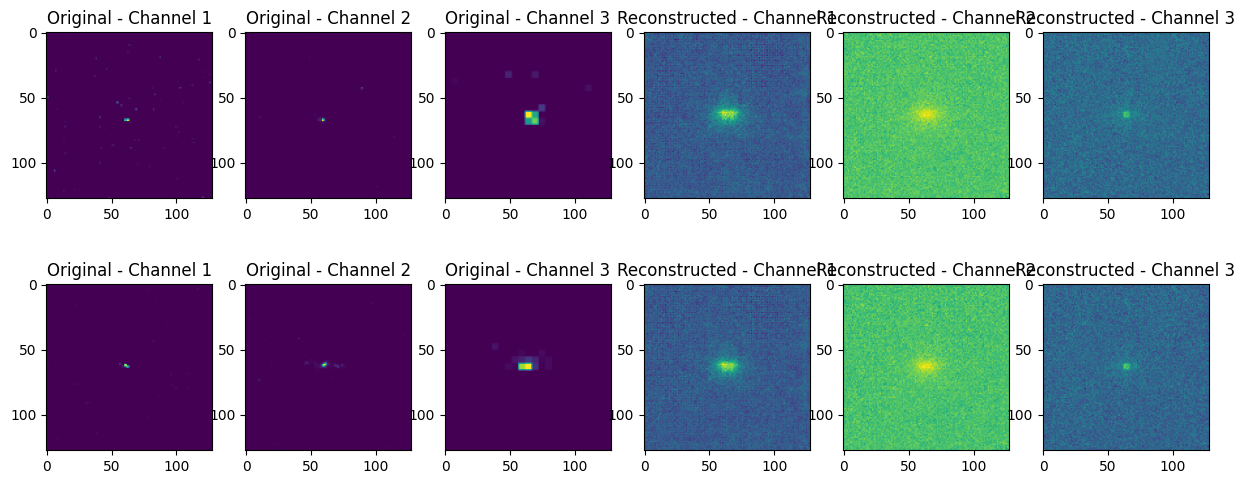

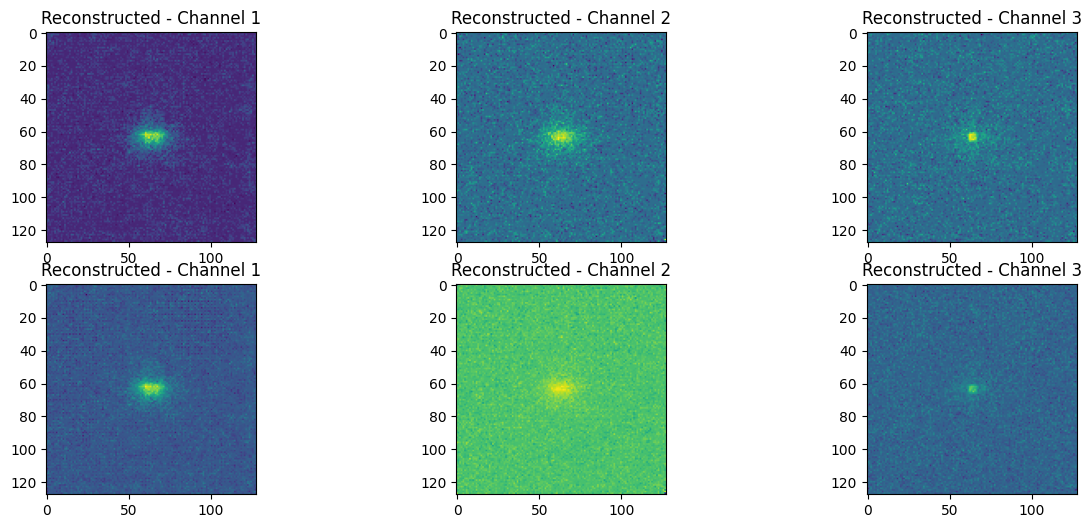

Test Epoch 20 | Loss: 5413.136719 | Recon Loss: 5132.890625 | KLD: 280.246246


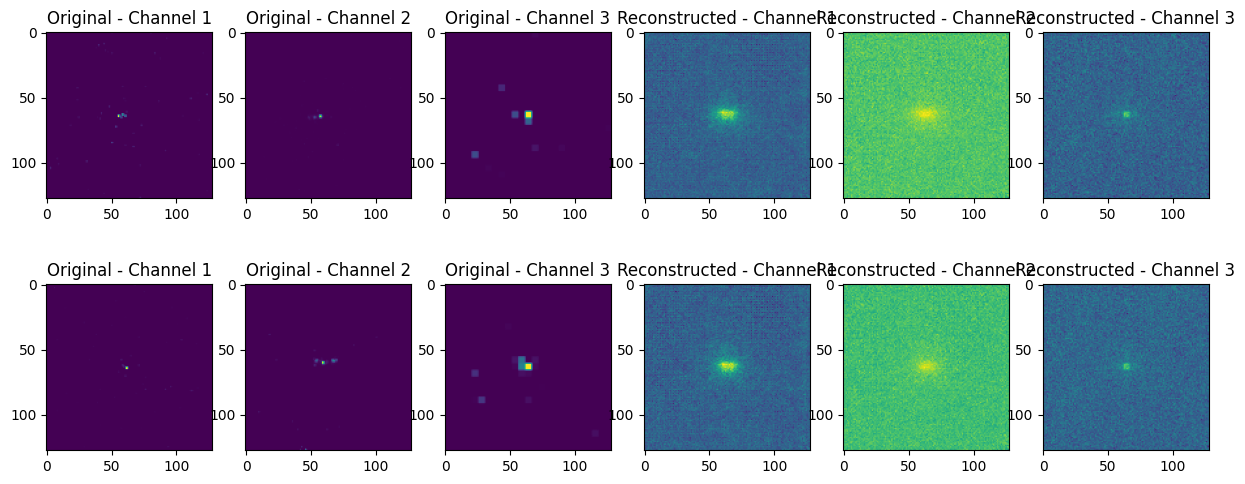

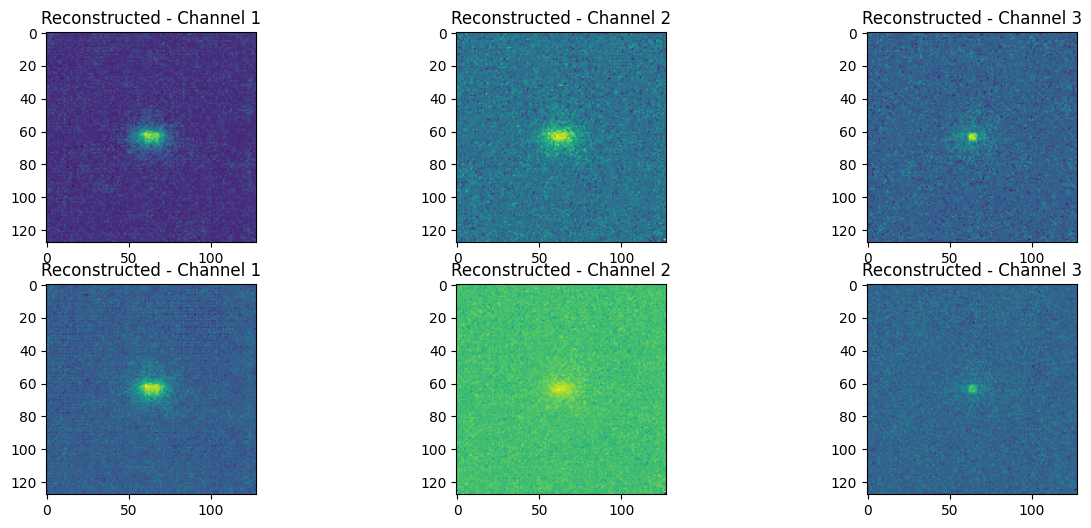

Checkpoint saved at /kaggle/working/vae_checkpoint_19.pth


Epoch 21/30: 100%|██████████| 75/75 [01:03<00:00,  1.19it/s, kld=191.2528, loss=1153.2883, recon=962.0355]   


Epoch 21 | Loss: 6978.941624 | Recon Loss: 6846.048156 | KLD: 132.893443


Epoch 22/30: 100%|██████████| 75/75 [01:04<00:00,  1.16it/s, kld=188.1440, loss=1314.8903, recon=1126.7463]


Epoch 22 | Loss: 5318.010907 | Recon Loss: 5131.623031 | KLD: 186.387889


Epoch 23/30: 100%|██████████| 75/75 [01:04<00:00,  1.16it/s, kld=186.4108, loss=1271.9342, recon=1085.5234]


Epoch 23 | Loss: 5254.933791 | Recon Loss: 5068.151445 | KLD: 186.782357


Epoch 24/30: 100%|██████████| 75/75 [01:05<00:00,  1.15it/s, kld=188.7219, loss=1251.7346, recon=1063.0127]


Epoch 24 | Loss: 5193.780251 | Recon Loss: 5006.651029 | KLD: 187.129210


Epoch 25/30: 100%|██████████| 75/75 [01:04<00:00,  1.16it/s, kld=189.0706, loss=1201.8368, recon=1012.7662]


Epoch 25 | Loss: 5132.230799 | Recon Loss: 4943.960470 | KLD: 188.270334


Epoch 26/30: 100%|██████████| 75/75 [01:05<00:00,  1.14it/s, kld=194.3466, loss=1574.5913, recon=1380.2446]


Epoch 26 | Loss: 5067.345046 | Recon Loss: 4878.040007 | KLD: 189.305033


Epoch 27/30: 100%|██████████| 75/75 [01:05<00:00,  1.15it/s, kld=193.7865, loss=1317.9596, recon=1124.1731]


Epoch 27 | Loss: 5003.637521 | Recon Loss: 4813.303337 | KLD: 190.334196


Epoch 28/30: 100%|██████████| 75/75 [01:05<00:00,  1.15it/s, kld=197.0150, loss=1215.5846, recon=1018.5696]


Epoch 28 | Loss: 4936.699292 | Recon Loss: 4745.251911 | KLD: 191.447388


Epoch 29/30: 100%|██████████| 75/75 [01:04<00:00,  1.16it/s, kld=194.2686, loss=1045.3383, recon=851.0696] 


Epoch 29 | Loss: 4870.583914 | Recon Loss: 4678.470745 | KLD: 192.113186


Epoch 30/30: 100%|██████████| 75/75 [01:05<00:00,  1.15it/s, kld=191.8362, loss=1200.4978, recon=1008.6616]

Epoch 30 | Loss: 4806.465827 | Recon Loss: 4613.694977 | KLD: 192.770854


In [54]:
train_vae(VAE_model, train_dataloader, test_dataloader, optimizer, device, 30)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def load_checkpoint(model, optimizer, filename="vae_checkpoint.pth"):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, filename)

    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        epoch = checkpoint["epoch"]

        print(f"Checkpoint loaded from {checkpoint_path}, resuming from epoch {epoch}")
        return epoch
    else:
        print("No checkpoint found, starting from scratch")
        return 0  # Start from epoch 0 if no checkpoint exists


In [ ]:
save_checkpoint(VAE_model, optimizer, 0)

**Inferences**

1. Using a weighted MSE loss resulted in better reconstructions by reducing the influence of zero-valued pixels.
2. A latent space size of 64 to 128 provided the best trade-off between reconstruction accuracy and model complexity.
3. The reconstructions tended to be noisy regardless of the loss function used, indicating a limitation of the VAE or data format. Hence it is better to shift to a graph based dataset and utilizing GNNS for the task.
4. The model often produced reconstructions that were mean representations of the input data (bright regions at the centre with noise arouund it) showing that the model was not able to learn any meaningful representation of the datapoinst regardless of any other factors(model complexity, latent size etc..).
5. A linear beta schedule did not really help in improving perfromance as the initialy the reconstruction would improve but then the model would collapse to a mean representation and the KLD would increase rapidly indicating that the latent representation being learned is not meaningful and the reconstruction loss would then plateau and remain constant.
6. Applying any activation to the final output did not create any positive effects. ReLU and LeakyReLU caused very sparse reconstructions (model was not really learning), sigmoid also did not make any major improvements to the reconstruction and KLD loss hence it was best to keep the final layer output without any activation. 
7. Further tuning of the β factor(cyclic β scheduler), using advanced loss functions might help mitigate the noise and improve reconstruction quality.